# Lab 10: Density-Based Clustering

### Learning Objectives

By the end of this lab, you will:
1. Diagnose when traditional clustering fails for irregular customer patterns
2. Apply density-based methods (Mean Shift, DBSCAN) to handle complex shapes
3. Interpret noise detection as business insight rather than algorithm failure
4. Evaluate hyperparameter selection using systematic approaches
5. Compare probabilistic clustering (GMM) with deterministic methods

# Imports and Data Loading


In [2]:
# ALL imports for the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NEW LIBS 
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')
# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_palette("husl")


In [ ]:
# Helper function from previous labs
def get_ss(df, features):
    """Calculate total sum of squares (SST)"""
    return np.sum(df[features].var() * (df[features].count() - 1))

def get_ssw(df, features, labels):
    """Calculate within-cluster sum of squares (SSW)"""
    df_temp = df[features].copy()
    df_temp['labels'] = labels
    return df_temp.groupby('labels')[features].apply(lambda x: get_ss(x, features)).sum()

def get_rsq(df, features, labels):
    """Calculate R² for clustering quality"""
    sst = get_ss(df, features)
    ssw = get_ssw(df, features, labels)
    return 1 - (ssw / sst)

Helper functions defined


In [7]:
# Load preprocessed retail customer data
df = pd.read_csv('../data/data_preprocessed.csv')
print(f"Dataset: {df.shape[0]} customers, {df.shape[1]} features")
df.head()

Dataset: 8817 customers, 32 features


,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Married,oh_status_Single,oh_status_Together,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
# Define metric features for clustering (ALL 10 features)
metric_features = [
    'income',           # Annual income
    'frq',              # Purchase frequency
    'rcn',              # Recency of last purchase
    'clothes',          # Spending on clothing
    'kitchen',          # Kitchen items spending
    'small_appliances', # Small appliances spending
    'toys',             # Toy purchases
    'house_keeping',    # Housekeeping products spending
    'per_net_purchase', # Average purchase value
    'spent_online'      # Online channel spending
]

print(f"Clustering features: {len(metric_features)}")
print(f"Features: {metric_features}")

Clustering features: 10
Features: ['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping', 'per_net_purchase', 'spent_online']


# K-means Limitations

- **Spherical assumption:** K-means assumes globular clusters
- **Forced assignment:** Every point must belong to a cluster, even when they don't belong. Valuable edge cases get lost in averages
- **Outlier sensitivity:** Extreme values distort centroids


**Common Misconception:** "Outliers are always data errors"  
**Reality:** In customer data, outliers often represent high-value or special-attention customers

.

.

. 

. 

Let's explore three density-based methods that handle these challenges

# Mean Shift 

Single seed             |  Multiple seeds
:-------------------------:|:-------------------------:
![](../figures/clustering/mean_shift_0.gif)  |  ![](../figures/clustering/mean_shift_tutorial.gif)
 
### Characteristics:
- No need to define number of clusters apriori
- Can detect clusters of any shape
- Robust to outliers
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth)

### Defining bandwidth:

- Too small creates micro-clusters
- Too large merges everything

Mean Shift Algorithm, showing initial and final locations of seeds with varying bandwidth values.

![](../figures/clustering/ms_q_bw_start_end.png)

No "correct" number of clusters - depends on business needs and operational capacity
- Detailed analysis 
- Manageable campaigns 

The `estimate_bandwidth()` function uses nearest neighbors to find optimal neighborhood size.

**How estimate_bandwidth works:**
1. Specify `quantile`: 
    - Determines `n_neighbors` to include when computing distances
2. For each points calculate `n_neighbors` nearest neighbors 
3. Get the largest distance to the `n_neighbors` 
3. Average of these largest distances 

In [ ]:
# CORRECT approach - data-driven bandwidth
bandwidth = estimate_bandwidth(df[metric_features], quantile=0.06, random_state=1)
bandwidth

0.06 quantile bandwidth: 2.320


In [ ]:
# Apply Mean Shift with estimated bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
    # bin_seeding=True for faster convergence (bins defined by bandwidth); default False, uses all points as seeds
    # n_jobs=4 to use 4 CPU cores for parallel processing; default is 1 (no parallelism)

ms_labels = ms.fit_predict(df[metric_features])

In [ ]:
n_clusters = len(np.unique(ms_labels))

print(pd.Series(ms_labels).value_counts().sort_index())

0    7418
1     641
2     393
3     365
Name: count, dtype: int64


In [26]:
r2 = get_rsq(df, metric_features, ms_labels)
print(f"R² score: {r2:.4f}")

R² score: 0.2097


## Homework 
- Test Mean Shift with quantile valyes: 0.03, 0.06, 0.12 
- For each record number of segments and $R^2$ score (or other metric) 
- Compare results and interpret business trade-offs (granularity vs manageability)

# DBSCAN 

### Density-based spatial clustering of applications with noise

DBSCAN animation            |  Core, border and noise
:-------------------------:|:-------------------------:
![](../figures/clustering/dbscan.gif)  |  ![](../figures/clustering/dbscan.jpg)

[Also see here](https://claude.ai/public/artifacts/b0b283c8-564e-402b-9f47-e13a85d9986e)

### Characteristics:
- No need to define number of clusters apriori
- Resistant to noise and outliers
- Can **identify outliers**
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

### Defining eps and min_samples

*Square markers are noise points* 

![](../figures/clustering/dbscan_eps_minpts.png)

- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. 

The assumption is that for points **in a cluster**, their k nearest neighbors are at roughly the same distance. **Noise points** have their k-th nearest neighbors at farther distance

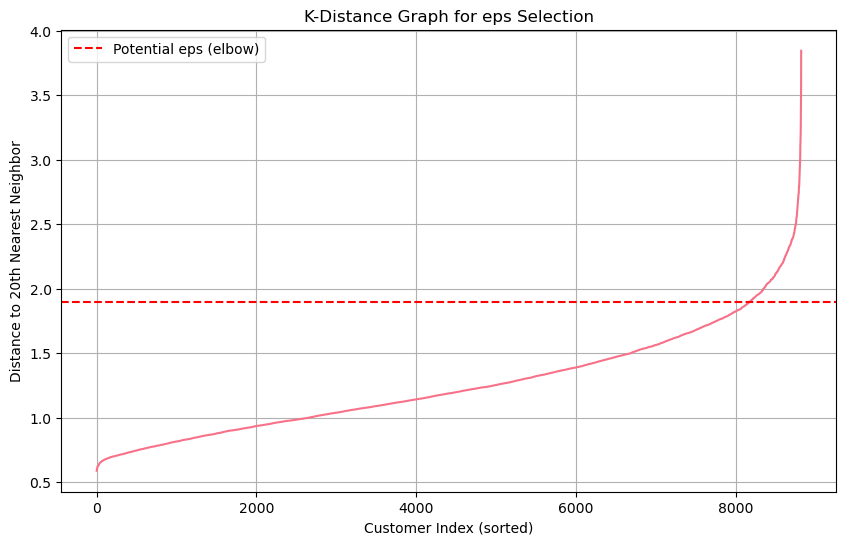

In [ ]:
# Find optimal eps using K-distance method
neigh = NearestNeighbors(n_neighbors=20) # n_features * 2 as a rule of thumb
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
# matrix of n_samples x n_neighbors nearest neighbors distances
distances = np.sort(distances[:, -1])
# distances for every sample to the 20th nearest neighbor, sorted


plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph for eps Selection")
plt.xlabel("Customer Index (sorted)")
plt.ylabel("Distance to 20th Nearest Neighbor")
plt.grid(True)

plt.axhline(y=1.9, color='r', linestyle='--', label='Potential eps (elbow)')

plt.legend()
plt.show()


In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df[metric_features])


Number of estimated clusters : 2


In [36]:
np.unique(dbscan_labels)

array([-1,  0])

In [69]:
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,-1
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0
...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,0
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,0
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,0


In [70]:
df_concat['dbscan_labels'].value_counts().sort_index()

dbscan_labels
-1     793
 0    8024
Name: count, dtype: int64

#### Do you expect a high or low $R^2$?

. 

.

.

In [71]:
r2_db = get_rsq(df, metric_features, dbscan_labels)
print(f"DBSCAN R² score: {r2_db:.4f}")

DBSCAN R² score: 0.0715


- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

### Exercise 
- Profile DBSCAN noide customers for business insights

In [1]:
# Metric features profiling 


In [3]:
# Profile for Education 


# Gaussian Mixture Models (GMM) 

<p align="center">
  <img src="../figures/clustering/gmm.gif" />
</p>

### Characteristics:
- Assumes the data is generated from a **mixture of finite number of Gaussian distributions** with **unknown parameters**
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with elipsoid cluster shapes (and also spherical)
    - Number of components needs to be defined apriori

[Read More](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

[See here also](https://claude.ai/public/artifacts/cf53f420-f238-41ce-a522-6566533068e5)

### Defining covariance_type:

This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

![](../figures/clustering/gmm_covariance.png)

- `covariance_type="tied"` makes all components share the same general covariance matrix

![](../figures/clustering/gmm_components_covars.png)

### Defining n_components:

**AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. The smaller the better.

**BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). The smaller the better.

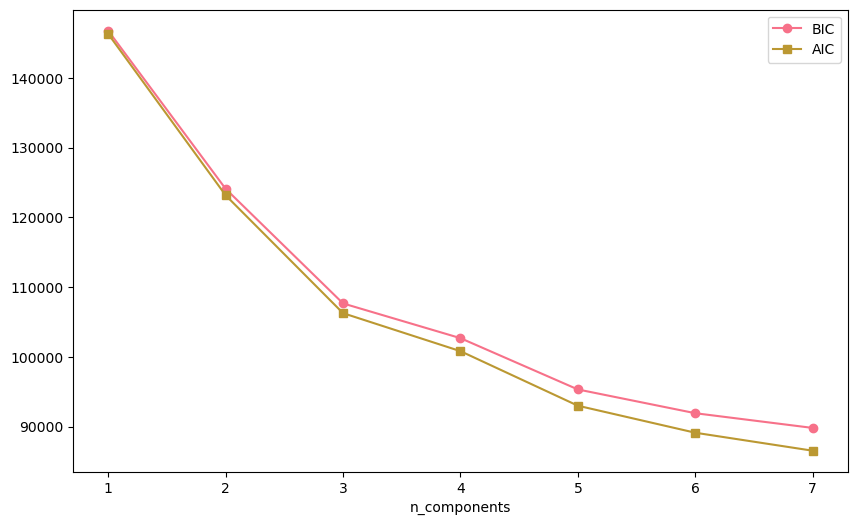

In [55]:
# This may take a while to run
# 
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 8)

models = []
for n in n_components:
    model = GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
    models.append(model)

bic_values = [m.bic(df[metric_features]) for m in models]
aic_values = [m.aic(df[metric_features]) for m in models]

plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

In [ ]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)

gmm_labels = gmm.fit_predict(df[metric_features])

In [56]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)

df_concat['gmm_labels'].value_counts().sort_index()

gmm_labels
0    3150
1    2718
2    2949
Name: count, dtype: int64

In [52]:
r2_gmm = get_rsq(df, metric_features, gmm_labels)
print(f"GMM R² score: {r2_gmm:.4f}")

GMM R² score: 0.3647


**Let's look at the estimated parameters:** 

In [ ]:
gmm.weights_

In [ ]:
print(gmm.means_.shape)
gmm.means_

In [ ]:
gmm.covariances_.shape

In [60]:
probabilities = gmm.predict_proba(df[metric_features])
probabilities

array([[1.73649359e-10, 1.46398505e-32, 1.00000000e+00],
       [5.38729796e-15, 6.89581588e-81, 1.00000000e+00],
       [1.06233788e-55, 1.00000000e+00, 1.54492975e-16],
       ...,
       [1.29360323e-01, 8.70639677e-01, 9.02789283e-25],
       [4.73526833e-09, 8.08559561e-09, 9.99999987e-01],
       [9.96788065e-01, 8.56369922e-99, 3.21193514e-03]])

In [65]:
max_probs = probabilities.max(axis=1)

uncertain_threshold = 0.7

certain_customers = df[max_probs >= uncertain_threshold]
uncertain_customers = df[max_probs < uncertain_threshold]

print(f"GMM Probability Analysis:")
print(f"- Clear assignments (≥70% probability): {len(certain_customers):,} customers")
print(f"- Uncertain assignments (<70% probability): {len(uncertain_customers):,} customers ({len(uncertain_customers)/len(df):.1%})")


GMM Probability Analysis:
- Clear assignments (≥70% probability): 8,414 customers
- Uncertain assignments (<70% probability): 403 customers (4.6%)


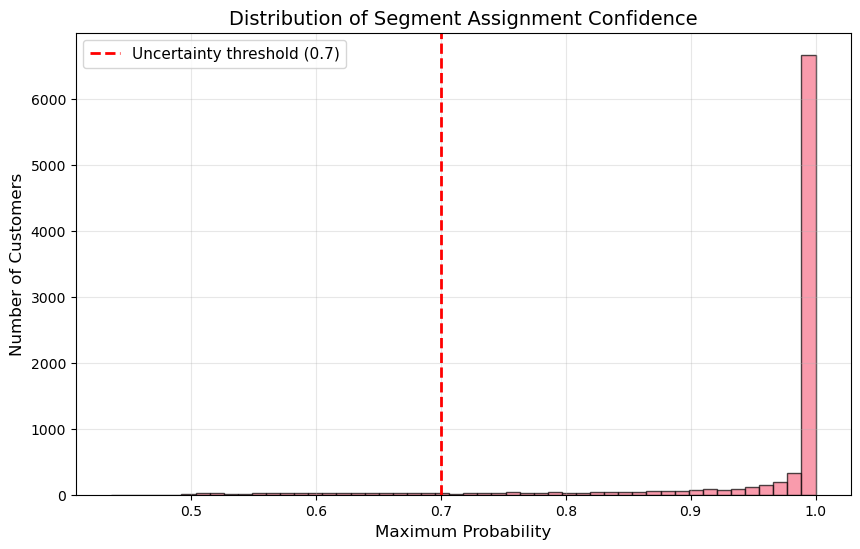

In [64]:
# Show probability distribution
plt.figure(figsize=(10,6))
plt.hist(max_probs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=uncertain_threshold, color='r', linestyle='--', linewidth=2, 
            label=f'Uncertainty threshold ({uncertain_threshold})')
plt.xlabel('Maximum Probability', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Distribution of Segment Assignment Confidence', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

- How would marketing use probability scores < 0.7?

### Exercise: Advanced Integration Scenarios

**Objective:** Apply density-based methods to realistic business scenarios.

**Instructions:**
For each scenario, recommend appropriate method(s) and implementation strategy.

#### Scenario A: Segment Misfits
- Lab 9 revealed 5 clear demographic/behavioral segments, but 200 customers don't fit well into any perspective.

#### Scenario B: Campaign Budget Optimization

- Marketing wants confidence scores for segment assignments to optimize campaign budgets and avoid wasting resources on uncertain assignments.

#### Scenario C: Segment Count Validation

- Lab 9's optimal K varies by perspective (demographic=3, behavioral=4, as an example). Executives want validation of true number of natural customer groups.


# Congratulations!

You've completed Lab 14 on Density-Based Clustering. You now understand:

- When traditional clustering methods fail
- How to apply Mean Shift for natural pattern discovery
- How to use DBSCAN for systematic outlier identification
- How to leverage GMM for probability-based assignments
- When to use each method and how to integrate them

These techniques complement Lab 13's multi-perspective approach and provide powerful tools for handling complex customer segmentation challenges.

**Next steps:**
- Apply these methods to your course project
- Experiment with different parameter values
- Integrate with Lab 13 perspective-based results
- Consider combining multiple methods for comprehensive insights

To think: 
- Which method would identify VIP frequent flyers with unusual patterns?
- How could probability scores improve loyalty tier assignments?
